# Trajectory Recommendation using BPR Ranking and Active Learning

## 1. Overview

1. BPR ranking of POIs
1. Recommend a set of POIs given (start, end, length)
1. Recommend POI visit duration
1. Recommend visiting order

In [1]:
% matplotlib inline

import os, re, sys, time, pickle
import math, random, itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sop
from joblib import Parallel, delayed

In [2]:
random.seed(987654321) # control random choice when splitting training/testing set
np.random.seed(987654321)

In [3]:
data_dir = 'data/data-ijcai15'
#fvisit = os.path.join(data_dir, 'userVisits-Osak.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Osak.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Glas.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Glas.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Edin.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Edin.csv')
fvisit = os.path.join(data_dir, 'userVisits-Toro.csv')
fcoord = os.path.join(data_dir, 'photoCoords-Toro.csv')

In [4]:
suffix = fvisit.split('-')[-1].split('.')[0]
fseqpart = os.path.join(data_dir, 'seqPart-' + suffix + '.pkl')

In [5]:
visits = pd.read_csv(fvisit, sep=';')
coords = pd.read_csv(fcoord, sep=';')
assert(visits.shape[0] == coords.shape[0])
traj = pd.merge(visits, coords, on='photoID') # merge data frames according to column 'photoID'
#traj.head()

In [6]:
num_photo = traj['photoID'].unique().shape[0]
num_user = traj['userID'].unique().shape[0]
num_poi = traj['poiID'].unique().shape[0]
num_seq = traj['seqID'].unique().shape[0]
pd.DataFrame({'#photo': num_photo, '#user': num_user, '#poi': num_poi, '#seq': num_seq, \
              '#photo/user': num_photo/num_user, '#seq/user': num_seq/num_user}, index=[str(suffix)])

,#photo,#photo/user,#poi,#seq,#seq/user,#user
Toro,39419,28.257348,29,6057,4.341935,1395


## 2.1 Compute POI Information

Compute POI (Longitude, Latitude) as the average coordinates of the assigned photos.

In [7]:
poi_coords = traj[['poiID', 'photoLon', 'photoLat']].groupby('poiID').mean()
poi_coords.reset_index(inplace=True)
poi_coords.rename(columns={'photoLon':'poiLon', 'photoLat':'poiLat'}, inplace=True)

Extract POI category and visiting frequency.

In [8]:
poi_catfreq = traj[['poiID', 'poiTheme', 'poiFreq']].groupby('poiID').first()
poi_catfreq.reset_index(inplace=True)

In [9]:
poi_all = pd.merge(poi_catfreq, poi_coords, on='poiID')
poi_all.set_index('poiID', inplace=True)
poi_all.head()
#poi_all.to_csv(fpoi, index=True)

,poiTheme,poiFreq,poiLon,poiLat
poiID,,,,
1,Sport,3506,-79.379243,43.643183
2,Sport,609,-79.418634,43.632772
3,Sport,688,-79.380045,43.662175
4,Sport,3056,-79.389290,43.641297
6,Cultural,986,-79.392396,43.653662


## 2.2 Construct Travelling Sequences

In [10]:
seq_all = traj[['userID', 'seqID', 'poiID', 'dateTaken']].copy().groupby(['userID', 'seqID', 'poiID'])\
          .agg([np.min, np.max, np.size])
seq_all.columns = seq_all.columns.droplevel()
seq_all.reset_index(inplace=True)
seq_all.rename(columns={'amin':'arrivalTime', 'amax':'departureTime', 'size':'#photo'}, inplace=True)
seq_all['poiDuration(sec)'] = seq_all['departureTime'] - seq_all['arrivalTime']
seq_all.head()

,userID,seqID,poiID,arrivalTime,departureTime,#photo,poiDuration(sec)
0,10007579@N00,1,30,1346844688,1346844688,1,0
1,10012675@N05,2,6,1142731848,1142732445,4,597
2,10012675@N05,3,6,1142916492,1142916492,1,0
3,10012675@N05,4,13,1319327174,1319332848,9,5674
4,10014440@N06,5,24,1196128621,1196128878,3,257


In [11]:
seq_user = seq_all[['userID', 'seqID', 'poiID']].copy().groupby(['userID', 'seqID']).agg(np.size)
seq_user.reset_index(inplace=True)
seq_user.rename(columns={'poiID':'seqLen'}, inplace=True)
seq_user.set_index('seqID', inplace=True)
seq_user.head()

,userID,seqLen
seqID,,
1,10007579@N00,1
2,10012675@N05,1
3,10012675@N05,1
4,10012675@N05,1
5,10014440@N06,1


In [12]:
def extract_seq(seqid, seq_all):
    seqi = seq_all[seq_all['seqID'] == seqid].copy()
    seqi.sort_values(by=['arrivalTime'], ascending=True, inplace=True)
    return seqi['poiID'].tolist()

## 2.3 Data Filtering 

Filtering out POI visits of which the duration is 0.

In [13]:
seq_all = seq_all[seq_all['poiDuration(sec)'] > 0]
seq_all.head()

,userID,seqID,poiID,arrivalTime,departureTime,#photo,poiDuration(sec)
1,10012675@N05,2,6,1142731848,1142732445,4,597
3,10012675@N05,4,13,1319327174,1319332848,9,5674
4,10014440@N06,5,24,1196128621,1196128878,3,257
5,10014440@N06,6,23,1198051767,1198052832,12,1065
6,10014440@N06,7,23,1198627025,1198627598,5,573


In [14]:
seq_stats = seq_all[['userID', 'seqID', 'poiID']].copy().groupby(['userID', 'seqID']).agg(np.size)
seq_stats.reset_index(inplace=True)
seq_stats.rename(columns={'poiID':'seqLen'}, inplace=True)
seq_stats.set_index('seqID', inplace=True)
seq_stats.head()

,userID,seqLen
seqID,,
2,10012675@N05,1
4,10012675@N05,1
5,10014440@N06,1
6,10014440@N06,1
7,10014440@N06,1


Filtering out sequences of which the length is less than 2.

In [15]:
seq_stats = seq_stats[seq_stats['seqLen'] > 2]
seq_stats.reset_index(inplace=True)
seq_stats.head()

,seqID,userID,seqLen
0,67,10502709@N05,3
1,100,10627620@N06,3
2,139,11090433@N05,4
3,166,11241023@N03,3
4,298,13644648@N03,7


In [16]:
seq_stats1 = seq_stats[['userID', 'seqID']].copy().groupby('userID').agg(np.size)
seq_stats1.rename(columns={'seqID':'#seq'}, inplace=True)

In [17]:
seq_stats1 = seq_stats1[seq_stats1['#seq'] >= 10]
seq_stats1.head()

,#seq
userID,
20741443@N00,13
84987970@N00,15


In [18]:
user_list = seq_stats1.index.tolist()
user_list.sort()
user_list

['20741443@N00', '84987970@N00']

In [19]:
seqid_list = seq_stats[seq_stats['userID'].isin(user_list)]['seqID'].tolist()
seqid_list.sort()
print(len(seqid_list))

28


## 2.4 Train vs. Query vs. Test Data

In [20]:
seq_exp_all = seq_all[seq_all['seqID'].isin(seqid_list)]
seq_exp_all.head()

,userID,seqID,poiID,arrivalTime,departureTime,#photo,poiDuration(sec)
900,20741443@N00,708,7,1160213392,1160224452,4,11060
901,20741443@N00,708,21,1160215990,1160216293,3,303
902,20741443@N00,708,23,1160214708,1160215087,3,379
904,20741443@N00,708,30,1160222055,1160222178,2,123
910,20741443@N00,712,7,1170541310,1170548979,7,7669


In [21]:
seq_exp_all['seqID'].unique()

array([ 708,  712,  729,  783,  788,  807,  809,  825,  905,  920,  923,
        979,  980, 5180, 5183, 5207, 5214, 5250, 5254, 5263, 5276, 5277,
       5278, 5282, 5301, 5324, 5328, 5337])

In [22]:
poi_list = seq_exp_all['poiID'].unique().tolist()
poi_list.sort()
poi_list

[2, 3, 4, 6, 7, 11, 16, 17, 21, 22, 23, 24, 25, 27, 28, 29, 30]

In [23]:
user_seqid_all = dict()
for user in user_list:
    user_seqid_all[user] = seq_exp_all[seq_exp_all['userID'] == user]['seqID'].unique()

In [24]:
train_percent = 0.2
query_percent = 0.5

In [25]:
user_seqid_train = dict()
user_seqid_query = dict()
user_seqid_test  = dict()

In [26]:
for user in user_list:
    rand_idx = np.random.permutation(user_seqid_all[user].shape[0])
    ntrain = round(train_percent*user_seqid_all[user].shape[0])
    nquery = round(query_percent*user_seqid_all[user].shape[0])
    user_seqid_train[user] = user_seqid_all[user][:ntrain]
    user_seqid_query[user] = user_seqid_all[user][ntrain:ntrain+nquery]
    user_seqid_test[user]  = user_seqid_all[user][ntrain+nquery:]

In [27]:
for user in user_list:
    tmparray = np.sort(np.r_[user_seqid_train[user], user_seqid_query[user], user_seqid_test[user]])
    assert(np.all(tmparray == np.sort(user_seqid_all[user])))

## 2.5 Construct User-POI Visiting Matrix

$M_{ij}$ denotes the number of visits for user $u_i$ at POI $p_j$, $NaN$ for non-observed visits.

In [28]:
def calc_visit_df(user_list, poi_list, user_seqid_tuples):
    # return a DataFrame counting the #visit at each POI for specified users
    visit_df = pd.DataFrame(data=np.full((len(user_list), len(poi_list)), np.nan), columns=poi_list, index=user_list)
    for tuple_ in user_seqid_tuples:
        user = tuple_[0]
        seqid = tuple_[1]
        seq = extract_seq(seqid, seq_exp_all)
        for poi in seq:
            if np.isnan(visit_df.loc[user, poi]):
                visit_df.loc[user, poi] = 1
            else:
                visit_df.loc[user, poi] += 1
    return visit_df

In [29]:
user_seqid_tuples_all = [(user, seqid) for user in user_list for seqid in user_seqid_all[user]]
#user_seqid_tuples_all
visit_all_df = calc_visit_df(user_list, poi_list, user_seqid_tuples_all)

In [30]:
visit_all_df

,2,3,4,6,7,11,16,17,21,22,23,24,25,27,28,29,30
20741443@N00,NaN,NaN,NaN,NaN,11,1,NaN,NaN,6,6,7,1,NaN,NaN,3,NaN,6
84987970@N00,1,5,2,2,5,NaN,1,1,9,12,7,1,1,1,7,2,3


In [31]:
nan_mask = np.isnan(visit_all_df)
masked_visit = np.ma.masked_array(visit_all_df, nan_mask)

In [32]:
visits = pd.Series(masked_visit.flatten())

In [33]:
visits.describe()

count    24.000000
mean      4.208333
std       3.387691
min       1.000000
25%       1.000000
50%       3.000000
75%       6.250000
max      12.000000
dtype: float64

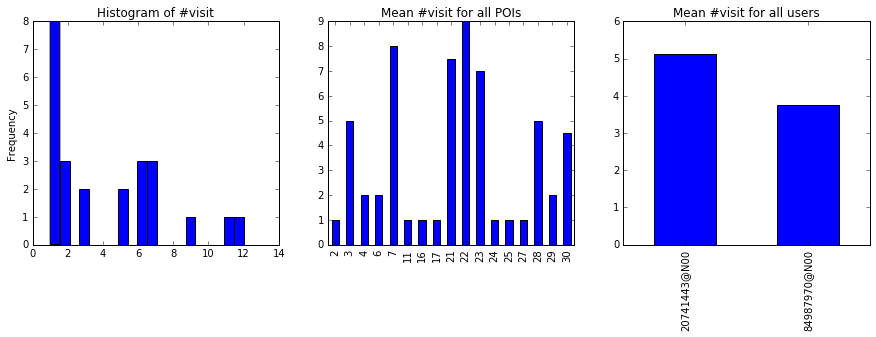

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

visits.plot(kind='hist', ax=ax1, bins=20, grid=False, title='Histogram of #visit')

poi_means = visit_all_df.mean(axis=0, skipna=True)
poi_means.plot(kind='bar', ax=ax2, grid=False, title='Mean #visit for all POIs')

user_means = visit_all_df.mean(axis=1, skipna=True)
user_means.plot(kind='bar', ax=ax3, grid=False, title='Mean #visit for all users')

In [35]:
user_seqid_tuples_train0 = [(user, seqid) for user in user_list for seqid in user_seqid_train[user]]
#user_seqid_tuples_train0
visit_train_df0 = calc_visit_df(user_list, poi_list, user_seqid_tuples_train0)

In [36]:
visit_train_df0

,2,3,4,6,7,11,16,17,21,22,23,24,25,27,28,29,30
20741443@N00,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,1,1,3,NaN,NaN,NaN,NaN,NaN,2
84987970@N00,1,1,1,NaN,NaN,NaN,NaN,1,2,2,1,NaN,1,NaN,NaN,NaN,NaN


In [37]:
nan_mask_train = np.isnan(visit_train_df0)
masked_visit_train = np.ma.masked_array(visit_train_df0, nan_mask_train)

In [38]:
visits_train = pd.Series(masked_visit_train.flatten())

In [39]:
visits_train.describe()

count    13.000000
mean      1.538462
std       0.776250
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max       3.000000
dtype: float64

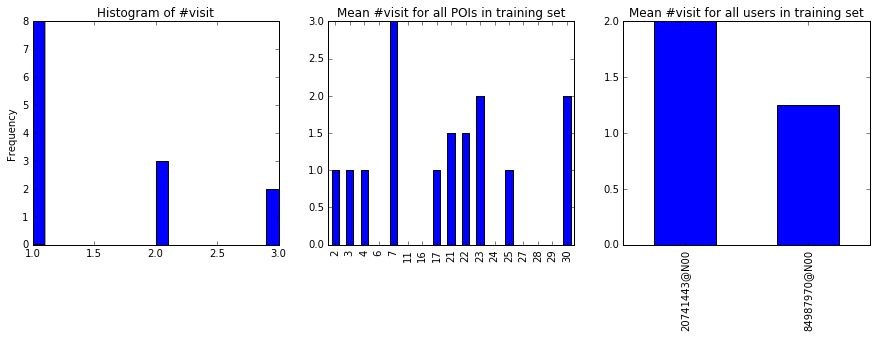

In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

visits_train.plot(kind='hist', ax=ax1, bins=20, grid=False, title='Histogram of #visit')

poi_means_train = visit_train_df0.mean(axis=0, skipna=True)
poi_means_train.plot(kind='bar', ax=ax2, grid=False, title='Mean #visit for all POIs in training set')

user_means_train = visit_train_df0.mean(axis=1, skipna=True)
user_means_train.plot(kind='bar', ax=ax3, grid=False, title='Mean #visit for all users in training set')

## 2.6 Training using BPR

Compute index $(u, i, j)$ for user $u$ and visited POI $i$ and unvisited POI $j$.

In [41]:
def calc_x_ind(visit_train_df):
    # return array that stores tuple (u, i, j)
    # user u
    # POI i: u visited POI i
    # POI j: u didn't visit POI j
    
    # NaN indicator matrix
    nan_ind = np.isnan(visit_train_df)
    #print(nan_ind)
    
    # array that stores tuple (u, i, j)
    x_ind = []
    for u in np.arange(visit_train_df.shape[0]):
        #print(np.nonzero(nan_ind.iloc[u])[0])
        unvisited_ind = np.nonzero(nan_ind.iloc[u])[0]
        visited_ind = np.nonzero(~nan_ind.iloc[u])[0]
        tuples_u = [[u, i, j] for i in visited_ind for j in unvisited_ind]
        if len(x_ind) == 0:
            x_ind = tuples_u
        else:
            x_ind = np.r_[x_ind, tuples_u]
        
    return x_ind

Sanity check.

In [42]:
#x_ind0 = calc_x_ind(visit_train_df)

In [43]:
#print(x_ind0)

Objective function and gradient of (negative) BPR-OPT.

In [44]:
def obj_func(Theta, x_ind, nUser, Lambda):
    """
    :param Theta: ndarray, feature vectors/matrix of user and POI
    :param x_ind: ndarray, array contains tuple (u, i, j)
    :param nUser: int, number of users
    :param Lambda: float, regularization parameter
    :return negative of BPR-OPT, gradient of negative BPR-OPT w.r.t. parameters
    """
    
    # user features
    Theta_u = Theta[:nUser]
    
    # POI features
    Theta_p = Theta[nUser:]
    
    # user features w.r.t. index u
    f_u = Theta_u[x_ind[:, 0]]
    
    # POI features w.r.t. index i
    f_i = Theta_p[x_ind[:, 1]]
    
    # POI features w.r.t. index j
    f_j = Theta_p[x_ind[:, 2]]
    
    assert(f_u.shape == f_i.shape == f_j.shape)
    
    # \hat{x}_{ui} = dot_product(feature vector of user u, feature vector of POI i)
    x_ui = [np.dot(f_u[idx], f_i[idx]) for idx in np.arange(x_ind.shape[0])]
    #print(x_ui)
    
    # \hat{x}_{uj}
    x_uj = [np.dot(f_u[idx], f_j[idx]) for idx in np.arange(x_ind.shape[0])]
    #print(x_uj)
    
    # \hat{x}_{uij} = \hat{x}_{ui} - \hat{x}_{uj}
    x_uij = np.array(x_ui) - np.array(x_uj)
    #print(x_uij)
    
    # sum( ln( sigmoid(x_uij) ))
    obj = np.sum(np.log(1. / (1. + np.exp(-x_uij))))
    
    # regularization term
    #obj -= Lambda * np.multiply(Theta, Theta).sum() # causes math overflow when lambda=1
    
    # compute (negative) gradient of (negative) BPR-OPT w.r.t. model parameters
    # for SGD, just compute gradients given a random tuple (u, i, j) 
    grad_u = np.zeros_like(Theta_u, dtype=np.float)
    grad_p = np.zeros_like(Theta_p, dtype=np.float)   
    idx = np.random.choice(np.arange(x_ind.shape[0]))
    u, i, j = x_ind[idx]
    grad_u[u] = Theta_p[i] - Theta_p[j]
    grad_p[i] = Theta_u[u]
    grad_p[j] = -Theta_u[u]
    
    tmpval = math.exp(-x_uij[idx])
    grad = -tmpval / (1 + tmpval) * np.r_[grad_u, grad_p]
    #grad -= Lambda * Theta # regularization term # causes math overflow when lambda=1
    
    return obj, grad

In [45]:
def learn_BPR_SGD(visit_train_df, Theta0, Lambda, Alpha=1e-2, maxIter=1e6, ftol=1e-9):
    # learning procedure, maximize BPR-OPT w.r.t model parameters using stochastic gradient descent
    # return model parameters and objective history
    
    # number of users
    nUser = visit_train_df.shape[0]
    
    # index (u, i, j)
    x_ind = calc_x_ind(visit_train_df)
    
    Theta = Theta0.copy()
    
    nit = 0
    obj_prev = 0
    obj_history = []
    printstep = round(maxIter / 10, 2)
    
    while True:
        f, df = obj_func(Theta, x_ind, nUser, Lambda)
        if abs(obj_prev - f) < ftol or nit > maxIter:
            break
        obj_prev = f
        Theta -= Alpha * df
        obj_history.append(f)
        if nit % printstep == 0:
            print('Iteration %d, Objective: %.8f' % (nit, f)); sys.stdout.flush()
        nit += 1
            
    print('Iteration %d, Objective: %.8f' % (nit, obj_history[-1]))
    print('diff: %f' % np.abs(Theta - Theta0).sum())
    
    return Theta, obj_history
    
    #'Desired error not necessarily achieved due to precision loss.'
    #Theta = Theta0.reshape(np.prod(Theta0.shape)) # reshape to 1-dimension vector
    # minimize objective function using stochastic gradient descent (encoded in obj_func)
    # using scipy.minimize
    #result = sop.minimize(fun=obj_func, x0=Theta, args=(x_ind, nUser, Lambda), jac=True)
    #print(result)
    #if result.success:
        #return result.x.reshape(Theta0.shape)
    #else:
        #return None

In [46]:
# dimension for hidden features
# for each user: a DIM feature vector
# for each POI: a DIM feature vector
DIM = 10

# regularization constant
Lambda = 1e-5

# learning rate
Alpha = 0.01

# maximum number of iteration
maxIter = 1e6

# feature matrix
# for users: |U| x DIM
# for POIs: |POI| x DIM
Theta0 = np.random.rand(len(user_list) + len(poi_list), DIM)

In [47]:
Theta, history = learn_BPR_SGD(visit_train_df0, Theta0, Lambda, Alpha, maxIter)

Iteration 0, Objective: -109.87386597
Iteration 100000, Objective: -0.03697523
Iteration 200000, Objective: -0.01642004
Iteration 300000, Objective: -0.01031260
Iteration 400000, Objective: -0.00742841
Iteration 500000, Objective: -0.00576530
Iteration 600000, Objective: -0.00469360
Iteration 700000, Objective: -0.00394517
Iteration 719829, Objective: -0.00382347
diff: 81.519986


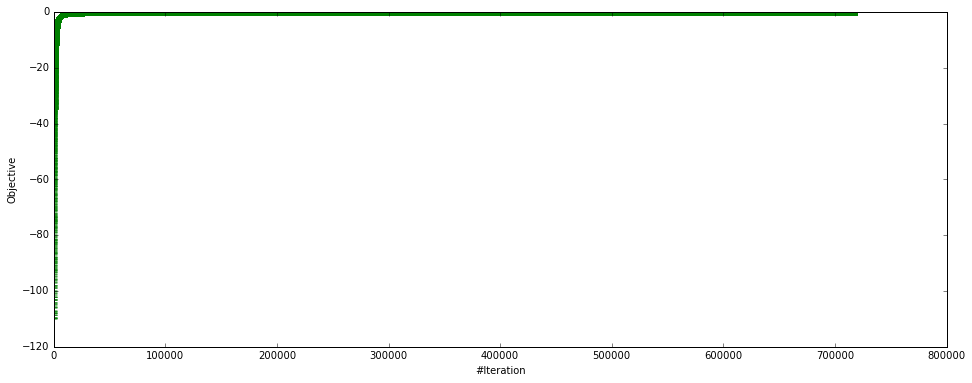

In [48]:
plt.figure(figsize=[16, 6])
plt.xlabel('#Iteration')
plt.ylabel('Objective')
plt.plot(np.arange(len(history)), history, ls='--', marker='+', color='g')

In [49]:
def calc_predicted_df(Theta, user_list, poi_list):
    nUser = len(user_list)
    Theta_u = Theta[:nUser] # user features
    Theta_p = Theta[nUser:] # POI features
    predicted_df = pd.DataFrame(data=np.zeros((nUser, len(poi_list)), dtype=np.float), columns=poi_list, index=user_list)
    for u in np.arange(len(user_list)):
        user = user_list[u]
        for p in np.arange(len(poi_list)):
            poi = poi_list[p]
            predicted_df.loc[user, poi] = np.dot(Theta_u[u], Theta_p[p])
    return predicted_df

In [50]:
def calc_compare_df(visited_df, predicted_df, scale_factor=1):
    userlist_ = predicted_df.index.tolist()
    poilist_ = predicted_df.columns.tolist()
    compare_df = pd.DataFrame(data=np.zeros((len(poilist_), 2*len(userlist_)), dtype=np.float), index=poilist_)
    for u in range(len(userlist_)):
        user = userlist_[u]
        compare_df.iloc[:, 2*u] = visited_df.loc[user]
        compare_df.iloc[:, 2*u+1] = np.round(predicted_df.loc[user]*scale_factor, 1)
        compare_df.rename(columns=\
                          {compare_df.columns[2*u]:'REAL_' + str(user), compare_df.columns[2*u+1]:'PRED_' + str(user)}, \
                          inplace=True)
    return compare_df

In [51]:
predicted_df = calc_predicted_df(Theta, user_list, poi_list)
predicted_df

,2,3,4,6,7,11,16,17,21,22,23,24,25,27,28,29,30
20741443@N00,2.275346,1.974749,1.984462,2.175081,12.117608,1.778905,0.516224,2.229536,12.435821,12.353982,12.302821,1.203774,2.147599,1.666912,1.851245,1.664748,12.177024
84987970@N00,10.469863,10.726733,10.670921,-1.021348,0.542807,-0.159653,0.447198,10.656986,10.692132,11.005219,11.071115,0.309677,10.549592,0.127433,0.137684,0.237142,0.524658


In [52]:
compare_df = calc_compare_df(visit_all_df, predicted_df)
compare_df

,REAL_20741443@N00,PRED_20741443@N00,REAL_84987970@N00,PRED_84987970@N00
2,NaN,2.3,1,10.5
3,NaN,2.0,5,10.7
4,NaN,2.0,2,10.7
6,NaN,2.2,2,-1.0
7,11,12.1,5,0.5
11,1,1.8,NaN,-0.2
16,NaN,0.5,1,0.4
17,NaN,2.2,1,10.7
21,6,12.4,9,10.7
22,6,12.4,12,11.0


Compute the ranking order error, i.e. visited POI should ranked above unvisited POI, otherwise it's an error.

In [53]:
def calc_order_error(visited_df, predicted_df):
    error_rates = dict()
    nan_ind = np.isnan(visited_df) # NaN indicator matrix
    for u in range(visited_df.shape[0]):
        unvisited_ind = np.nonzero(nan_ind.iloc[u])[0]
        visited_ind = np.nonzero(~nan_ind.iloc[u])[0]
        total = len(visited_ind) * len(unvisited_ind)
        error = 0
        for idx in unvisited_ind:
            #print(predicted_df.iloc[u, idx])
            #print(predicted_df.iloc[u, visited_ind].values)
            error += np.sum(predicted_df.iloc[u, idx] > predicted_df.iloc[u, visited_ind].values)
        #error_rates[predicted_df.index[u]] = [error / total, error, total]
        error_rates[predicted_df.index[u]] = error / total
    return error_rates

In [54]:
calc_order_error(visit_all_df, predicted_df)

{'20741443@N00': 0.27777777777777779, '84987970@N00': 0.0625}

In [55]:
train_error_rates0 = calc_order_error(visit_train_df0, predicted_df)
train_error_rates0

{'20741443@N00': 0.0, '84987970@N00': 0.0}

In [56]:
user_seqid_tuples_test0 = [(user, seqid) for user in user_list for seqid in user_seqid_test[user]]
visit_test_df0 = calc_visit_df(user_list, poi_list, user_seqid_tuples_test0)

In [57]:
test_error_rates0 = calc_order_error(visit_test_df0, predicted_df)
test_error_rates0

{'20741443@N00': 0.21428571428571427, '84987970@N00': 0.18181818181818182}

## 3. Recommendation with Query Strategies

In [58]:
def enum_poi_set(poi_list, startPOI, endPOI, nPOI):
    """
    Enumerate all possible subset of poi_list without startPOI and endPOI,
    The size of subset is nPOI-2
    """
    assert(nPOI > 2)
    assert(nPOI < len(poi_list))
    tuples = itertools.combinations([p for p in poi_list if p not in {startPOI, endPOI}], nPOI-2)
    terminals = [startPOI, endPOI]
    return [terminals.copy() + list(x) for x in tuples]

In [59]:
# sanity check
#possible_sets = enum_poi_set(poi_list, 7, 23, 3)
#print(poi_list)
#possible_sets

In [60]:
def calc_poi_set_distribution(poi_set_list, user, predicted_df):
    probs = np.zeros(len(poi_set_list), dtype=np.float)
    for i in range(len(poi_set_list)):
        probs[i] = predicted_df.loc[user, poi_set_list[i]].sum()
    #print(probs)
    probs /= probs.sum()
    return probs

In [61]:
# sanity check
#possible_sets = enum_poi_set(poi_list, 7, 23, 3)
#print(possible_sets)
#predicted_df.transpose()

In [62]:
#predicted_df.loc['20741443@N00', 7] + predicted_df.loc['20741443@N00', 23] + predicted_df.loc['20741443@N00', 30] 

In [63]:
#probs = calc_poi_set_distribution(possible_sets, '20741443@N00', predicted_df)
#probs

In [64]:
def calc_F1score(poi_set_act, poi_set_rec):
    assert(len(poi_set_act) > 0)
    assert(len(poi_set_rec) > 0)
    actset = set(poi_set_act)
    recset = set(poi_set_rec)
    intersect = actset & recset
    recall = len(intersect) / len(poi_set_act)
    precision = len(intersect) / len(poi_set_rec)
    F1score = 2. * precision * recall / (precision + recall)
    return F1score

In [65]:
def evaluate(Theta, user_list, poi_list, user_seqid_tuples_test):
    predicted_df = calc_predicted_df(Theta, user_list, poi_list)
    F1scores = []
    for user, seqid in user_seqid_tuples_test:
        poi_set_act = extract_seq(seqid, seq_exp_all)
        #print(poi_set_act)
        p_idx = predicted_df.loc[user].argsort()
        #print(p_idx)
        decreased = predicted_df.columns[p_idx.values][::-1]
        #print(decreased)
        poi_set_rec = [p for p in decreased if p not in {poi_set_act[0], poi_set_act[-1]}][:len(poi_set_act)-2]
        #print(poi_set_rec)
        poi_set_rec.extend([poi_set_act[0], poi_set_act[-1]])
        #print(poi_set_rec)
        F1 = calc_F1score(poi_set_act, poi_set_rec)
        #print(F1)
        F1scores.append(F1)
    return F1scores

Evaluation using algorithm trained by initial training set.

In [66]:
user_seqid_tuples_query0 = [(user, seqid) for user in user_list for seqid in user_seqid_query[user]]

In [67]:
Theta0 = np.random.rand(len(user_list) + len(poi_list), DIM)
Theta_init, history = learn_BPR_SGD(visit_train_df0, Theta0, Lambda, Alpha, maxIter)
F1scores_init = evaluate(Theta_init, user_list, poi_list, user_seqid_tuples_test0)
print('F1: (%.2f, %.2f)' % (np.mean(F1scores_init), np.std(F1scores_init)))

Iteration 0, Objective: -95.58195348
Iteration 100000, Objective: -0.03690923
Iteration 200000, Objective: -0.01638153
Iteration 300000, Objective: -0.01025967
Iteration 400000, Objective: -0.00738645
Iteration 500000, Objective: -0.00573446
Iteration 600000, Objective: -0.00466936
Iteration 700000, Objective: -0.00392440
Iteration 760377, Objective: -0.00357594
diff: 79.836887
F1: (0.72, 0.11)


In [68]:
predicted_df0 = calc_predicted_df(Theta_init, user_list, poi_list)
predicted_df0

,2,3,4,6,7,11,16,17,21,22,23,24,25,27,28,29,30
20741443@N00,2.045006,2.157343,1.852842,0.157882,11.998237,1.919923,0.194159,1.955331,12.095283,12.088179,12.046194,1.171281,2.043037,1.202840,1.007795,1.070159,12.005806
84987970@N00,10.760220,10.678558,10.784970,0.537852,0.654835,-0.459652,0.488188,10.785083,11.489155,11.399070,11.538944,0.180398,10.748520,0.343746,0.404408,0.408547,0.607779


## 3.1 Random Baseline

Random baseline, i.e. passive learning.

Trajectory recommendation mesures.

In [69]:
F1scores_rand = []
F1scores_rand.append(F1scores_init)

POI ranking mesures.

In [70]:
ranking_errors_train = [np.mean(list(train_error_rates0.values()))]
ranking_errors_test =  [np.mean(list(test_error_rates0.values()))]

In [71]:
visit_train_df = visit_train_df0.copy()
visit_test_df = visit_test_df0.copy()
user_seqid_tuples_query = user_seqid_tuples_query0.copy()
user_seqid_tuples_test = user_seqid_tuples_test0.copy()
Theta = Theta_init.copy()

In [72]:
tuples_idx = np.arange(len(user_seqid_tuples_query))
np.random.shuffle(tuples_idx)
for idx in tuples_idx:
    user = user_seqid_tuples_query[idx][0]
    seqid = user_seqid_tuples_query[idx][1]
    seq = extract_seq(seqid, seq_exp_all)
    print('choose: (%s, %s)' % (user, seq))
    for poi in seq:
        if np.isnan(visit_train_df.loc[user, poi]): 
            visit_train_df.loc[user, poi] = 1
        else:
            visit_train_df.loc[user, poi] += 1
    #Theta = np.random.rand(len(user_list) + len(poi_list), DIM) # random initialisation
    #Theta = Theta # use the previous optimised parameter as the initial value of the current optimisation
    Theta, history = learn_BPR_SGD(visit_train_df, Theta, Lambda, Alpha, maxIter)
    
    F1scores = evaluate(Theta, user_list, poi_list, user_seqid_tuples_test)
    F1scores_rand.append(F1scores)
    print('F1: (%.2f, %.2f)' % (np.mean(F1scores), np.std(F1scores)))
    
    # ranking order error
    predicted_df = calc_predicted_df(Theta, user_list, poi_list)
    err_train = np.mean(list(calc_order_error(visit_train_df, predicted_df).values()))
    err_test = np.mean(list(calc_order_error(visit_test_df, predicted_df).values()))
    ranking_errors_train.append(err_train)
    ranking_errors_test.append(err_test)
    print('mean ranking error: %.2f, %.2f' % (err_train, err_test))

choose: (84987970@N00, [7, 22, 23, 3])
Iteration 0, Objective: -4.39337339
Iteration 6889, Objective: -0.05768919
diff: 4.781625
F1: (0.84, 0.16)
mean ranking error: 0.00, 0.20
choose: (84987970@N00, [6, 22, 28, 21, 23, 30, 7])
Iteration 0, Objective: -8.08488216
Iteration 7500, Objective: -0.11498052
diff: 9.455690
F1: (0.84, 0.16)
mean ranking error: 0.00, 0.15
choose: (20741443@N00, [7, 21, 22])
Iteration 0, Objective: -0.11498053
Iteration 22, Objective: -0.11482211
diff: 0.002795
F1: (0.84, 0.16)
mean ranking error: 0.00, 0.15
choose: (84987970@N00, [21, 23, 28])
Iteration 0, Objective: -0.11482211
Iteration 9, Objective: -0.11481639
diff: 0.000231
F1: (0.84, 0.16)
mean ranking error: 0.00, 0.15
choose: (84987970@N00, [22, 29, 24])
Iteration 0, Objective: -4.25403114
Iteration 33, Objective: -3.63644656
diff: 0.293617
F1: (0.84, 0.16)
mean ranking error: 0.01, 0.15
choose: (20741443@N00, [23, 22, 28])
Iteration 0, Objective: -10.28903941
Iteration 145, Objective: -5.14534626
diff:

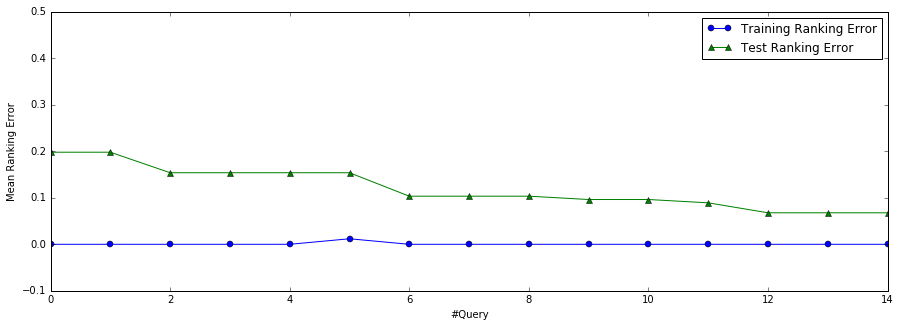

In [73]:
plt.figure(figsize=[15, 5])
plt.xlabel('#Query')
plt.ylabel('Mean Ranking Error')
plt.ylim([-0.1, 0.5])
plt.plot(np.arange(len(ranking_errors_train)), ranking_errors_train, label='Training Ranking Error', marker='o')
plt.plot(np.arange(len(ranking_errors_test)), ranking_errors_test, label='Test Ranking Error', marker='^')
plt.legend(loc='upper right')

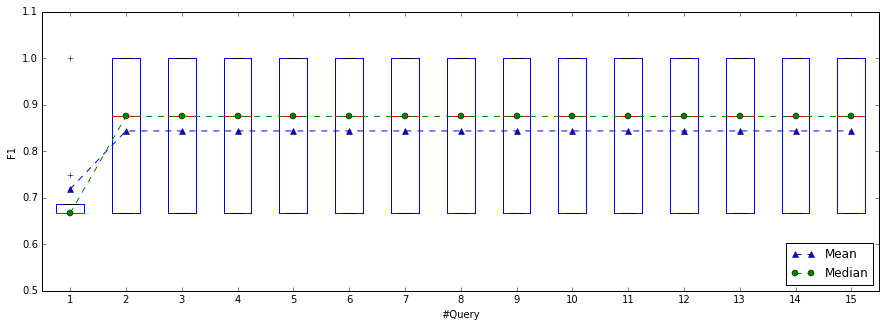

In [74]:
plt.figure(figsize=[15, 5])
plt.xlabel('#Query')
plt.ylabel('F1')
plt.ylim([0.5, 1.1])
plt.boxplot(F1scores_rand)
plt.plot(np.arange(1, len(F1scores_rand)+1), [np.mean(x) for x in F1scores_rand], marker='^', ls='--', label='Mean')
plt.plot(np.arange(1, len(F1scores_rand)+1), [np.median(x) for x in F1scores_rand], marker='o', ls='--', label='Median')
plt.legend(loc='lower right')

## 3.2 Least Confident

Relevant Definitions
- Example: $\textbf{x} = (P_s, P_e, \lvert Traj \rvert)$
- Label of Example: $\textbf{y} = Traj$
- Probability of Possible Label: Normalise the total ranking (i.e. sum the "number" for each POI in the trajectory) of all possible trajectories to form a probability distribution   
*NOT Good because the "number" for each POI only optimised for ranking purpose, i.e. the absolute value of the "number" for each POI is meaningless as long as "number" for visited POI is greater than "number" for unvisited POI.*

Trajectory recommendation mesures.

In [75]:
F1scores_lc = []
F1scores_lc.append(F1scores_init)

POI ranking mesures.

In [76]:
ranking_errors_train = [np.mean(list(train_error_rates0.values()))]
ranking_errors_test =  [np.mean(list(test_error_rates0.values()))]

In [77]:
visit_train_df = visit_train_df0.copy()
visit_test_df = visit_test_df0.copy()
user_seqid_tuples_query = user_seqid_tuples_query0.copy()
user_seqid_tuples_test = user_seqid_tuples_test0.copy()
predicted_df = predicted_df0.copy()
Theta = Theta_init.copy()

In [78]:
query_seqs = [extract_seq(x[1], seq_exp_all) for x in user_seqid_tuples_query]
while len(user_seqid_tuples_query) > 0:
    # choose the least confident example to query 
    seq_maxprobs = [max(calc_poi_set_distribution(\
                         enum_poi_set(poi_list, query_seqs[idx][0], query_seqs[idx][-1], len(query_seqs[idx])), \
                         user_seqid_tuples_query[idx][0], predicted_df)) for idx in range(len(user_seqid_tuples_query))] 
    seq_idx = np.argmin(seq_maxprobs) # least confident = 1 - maxprob
    user = user_seqid_tuples_query[seq_idx][0]
    seq = query_seqs[seq_idx]   

    print('choose: (%s, %s)' % (user, seq))
    for poi in seq:
        if np.isnan(visit_train_df.loc[user, poi]): 
            visit_train_df.loc[user, poi] = 1
        else:
            visit_train_df.loc[user, poi] += 1
    Theta, history = learn_BPR_SGD(visit_train_df, Theta, Lambda, Alpha, maxIter)
    
    F1scores = evaluate(Theta, user_list, poi_list, user_seqid_tuples_test)
    F1scores_lc.append(F1scores)
    print('F1: (%.2f, %.2f)' % (np.mean(F1scores), np.std(F1scores)))
    
    # remove the selected example after querying
    del user_seqid_tuples_query[seq_idx]
    del query_seqs[seq_idx]
    
    # ranking order error
    predicted_df = calc_predicted_df(Theta, user_list, poi_list)
    err_train = np.mean(list(calc_order_error(visit_train_df, predicted_df).values()))
    err_test = np.mean(list(calc_order_error(visit_test_df, predicted_df).values()))
    ranking_errors_train.append(err_train)
    ranking_errors_test.append(err_test)
    print('mean ranking error: %.2f, %.2f' % (err_train, err_test))

choose: (84987970@N00, [3, 21, 23, 28, 7, 30, 22])
Iteration 0, Objective: -10.20276546
Iteration 28569, Objective: -0.02923250
diff: 12.538481
F1: (0.80, 0.16)
mean ranking error: 0.00, 0.14
choose: (84987970@N00, [6, 22, 28, 21, 23, 30, 7])
Iteration 0, Objective: -3.29765871
Iteration 254, Objective: -1.54808926
diff: 0.897281
F1: (0.80, 0.16)
mean ranking error: 0.00, 0.14
choose: (84987970@N00, [29, 22, 28, 23, 21, 27])
Iteration 0, Objective: -4.48321768
Iteration 345, Objective: -1.87641278
diff: 1.691658
F1: (0.80, 0.16)
mean ranking error: 0.00, 0.15
choose: (84987970@N00, [7, 22, 23, 3])
Iteration 0, Objective: -1.87641278
Iteration 12, Objective: -1.81637278
diff: 0.058826
F1: (0.80, 0.16)
mean ranking error: 0.00, 0.15
choose: (20741443@N00, [7, 23, 28, 30])
Iteration 0, Objective: -6.76985440
Iteration 263, Objective: -2.77711013
diff: 2.098225
F1: (0.80, 0.16)
mean ranking error: 0.00, 0.13
choose: (84987970@N00, [21, 22, 6, 16])
Iteration 0, Objective: -3.78518927
Iterat

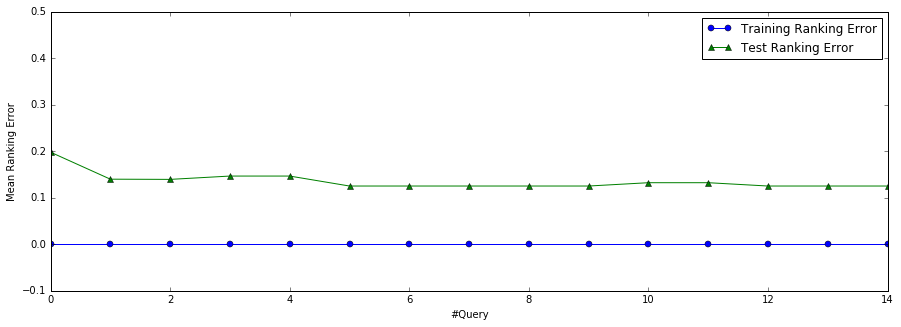

In [79]:
plt.figure(figsize=[15, 5])
plt.xlabel('#Query')
plt.ylabel('Mean Ranking Error')
plt.ylim([-0.1, 0.5])
plt.plot(np.arange(len(ranking_errors_train)), ranking_errors_train, label='Training Ranking Error', marker='o')
plt.plot(np.arange(len(ranking_errors_test)), ranking_errors_test, label='Test Ranking Error', marker='^')
plt.legend(loc='upper right')

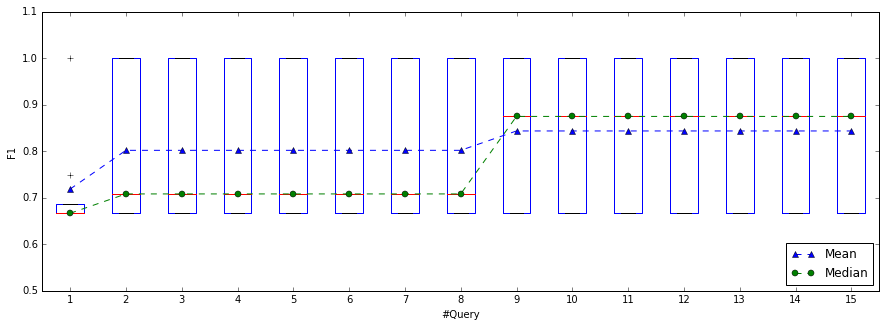

In [80]:
plt.figure(figsize=[15, 5])
plt.xlabel('#Query')
plt.ylabel('F1')
plt.ylim([0.5, 1.1])
plt.boxplot(F1scores_lc)
plt.plot(np.arange(1, len(F1scores_lc)+1), [np.mean(x) for x in F1scores_lc], marker='^', ls='--', label='Mean')
plt.plot(np.arange(1, len(F1scores_lc)+1), [np.median(x) for x in F1scores_lc], marker='o', ls='--', label='Median')
plt.legend(loc='lower right')

## 4. POI Visit Duration Prediction

In [224]:
#import pymc3 as pm
#import theano, theano.tensor as T
import pymc as pm
from pymc.Matplot import plot as mcplot

In [169]:
#theano.config.floatX = 'float32'
#theano.config.mode = 'FAST_RUN'
#theano.config.blas.ldflags = '-lopenblas'
#theano.config.compute_test_value = 'ignore'
#theano.config.gcc.cxxflags = '-O2'
#theano.config.compute_test_value = 'off'
#print(theano.config)

In [170]:
poi_duration_df = seq_exp_all[['userID', 'seqID', 'poiID', 'poiDuration(sec)']].copy()
poi_duration_df.set_index(['userID', 'seqID', 'poiID'], inplace=True)
poi_duration_df.head()

poiDuration(sec)
userID       seqID poiID                  
20741443@N00 708   7                 11060
                   21                  303
                   23                  379
                   30                  123
             712   7                  7669

In [171]:
poi_duration_df.loc[('20741443@N00', 708, 7), 'poiDuration(sec)']

11060

In [172]:
visit_duration_train = pd.DataFrame(data=np.full((len(user_list), len(poi_list)), np.nan, dtype=np.object), \
                                    columns=poi_list, index=user_list)

In [173]:
nan_mask_train = pd.DataFrame(data=np.ones(visit_duration_train.shape, dtype=np.bool), columns=poi_list, index=user_list)

In [174]:
tuples = [x for x in user_seqid_tuples_train0]
tuples.extend([x for x in user_seqid_tuples_query0])

In [175]:
for user, seqid in tuples:
    seq = extract_seq(seqid, seq_exp_all)
    for poi in seq:
        if np.all(np.isnan(visit_duration_train.loc[user, poi])):
            visit_duration_train.loc[user, poi] = np.array([poi_duration_df.loc[(user, seqid, poi), 'poiDuration(sec)']])
        else:
            visit_duration_train.loc[user, poi] = \
            np.r_[visit_duration_train.loc[user, poi], poi_duration_df.loc[(user, seqid, poi), 'poiDuration(sec)']]
        nan_mask_train.loc[user, poi] = False

In [176]:
visit_duration_train

,2,3,4,6,7,11,16,17,21,22,23,24,25,27,28,29,30
20741443@N00,NaN,NaN,NaN,NaN,"[11060, 7669, 1070, 511, 102, 30971, 21600]",[1678],NaN,NaN,"[303, 10030, 111, 3665]","[1910, 1829, 1969, 533, 2261]","[379, 7554, 14204, 2750, 4672, 18900]",NaN,NaN,NaN,"[2096, 13755]",NaN,"[123, 6, 31230, 12390]"
84987970@N00,[635],"[91, 523, 324]","[28, 295]","[31, 538]","[4974, 78, 159, 66]",NaN,[17],[15753],"[301, 375, 191, 422, 559, 18339, 61]","[6904, 68, 15, 21, 24349, 146, 143, 15]","[190, 233, 22152, 2625, 18688, 1707]",[3022],[9],[208],"[23019, 97, 20138, 195]","[21415, 4614]","[1773, 57, 536]"


In [177]:
visit_duration_train.iloc[0, 4]

array([11060,  7669,  1070,   511,   102, 30971, 21600])

DataFrames with block values can't be used as observations, use average value instead (trivial implementation).

In [178]:
visit_duration_train2 = pd.DataFrame(data=np.full(visit_duration_train.shape, np.nan, dtype=float), \
                                     columns=poi_list, index=user_list)

In [179]:
for user in visit_duration_train.index:
    for poi in visit_duration_train.columns:
        if not np.all(np.isnan(visit_duration_train.loc[user, poi])):
            visit_duration_train2.loc[user, poi] = np.mean(visit_duration_train.loc[user, poi])

In [180]:
visit_duration_train2

,2,3,4,6,7,11,16,17,21,22,23,24,25,27,28,29,30
20741443@N00,NaN,NaN,NaN,NaN,10426.142857,1678,NaN,NaN,3527.250000,1700.400,8076.500000,NaN,NaN,NaN,7925.50,NaN,10937.250000
84987970@N00,635,312.666667,161.5,284.5,1319.250000,NaN,17,15753,2892.571429,3957.625,7599.166667,3022,9,208,10862.25,13014.5,788.666667


### Build PMF model

In [241]:
def build_pmf(duration_train, mask, dim):
    """
    Build the Probabilistic Matrix Factorization model using pymc3.
    """
    obs_data = duration_train.copy()
    n, m = obs_data.shape
    print('obs_data:', obs_data.shape)
    print('dim:', dim)

    # Low precision reflects uncertainty; prevents overfitting.
    alpha_u = 0.01
    alpha_p = 0.01
    alpha = 1
    
    U = []
    P = []
    obs = []
    for i in range(n):
        U_i = pm.MvNormal(str('U_%d' % i), mu=np.zeros(dim), tau=alpha_u * np.eye(dim))
        U.append(U_i)
    for j in range(m):
        P_j = pm.MvNormal(str('P_%d' % j), mu=np.zeros(dim), tau=alpha_p * np.eye(dim))
        P.append(P_j)
    for i in range(n):
        for j in range(m):
            if not mask.iloc[i, j]:
                mu_ij = pm.sum([U[i][x] * P[j][x] for x in range(dim)])
                R_ij = pm.Normal(str('R_%d_%d' % (i, j)), mu=mu_ij, tau=alpha, \
                                 observed=True, value=duration_train.iloc[i, j])
                obs.append(R_ij)
                
    return pm.Model([x for x in U] + [x for x in P] + obs)

In [242]:
pmf = build_pmf(visit_duration_train, nan_mask_train, dim=5)

obs_data: (2, 17)
dim: 5


### Find the MAP

In [243]:
t0 = time.time()
#map_estimate = pm.find_MAP(model=pmf, fmin=sop.fmin_powell, disp=True)
map_ = pm.MAP(pmf)
map_.fit()
#map_.fit(method='fmin_powell')
print('%d seconds used.' % int(time.time() - t0))

3 seconds used.


### Run MCMC

In [276]:
mcmc = pm.MCMC(pmf)
mcmc.sample(1000000, burn=500000, thin=10)

 [-----------------100%-----------------] 1000000 of 1000000 complete in 2286.7 sec

Plotting P_5_0
Plotting P_5_1
Plotting P_5_2
Plotting P_5_3
Plotting P_5_4


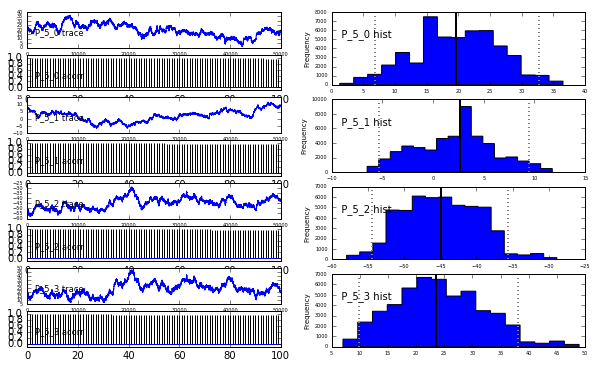

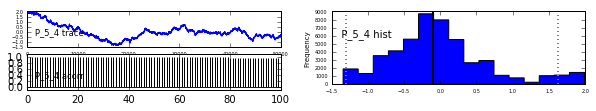

In [277]:
mcplot(mcmc.trace('P_5'), common_scale=False)

In [282]:
mcmc.trace('U_0')[:].mean(axis=0)

array([ 11.25519511,   3.14983623, -24.4573095 ,  14.73821042,   1.31553787])

### Compute Prediction Error

In [283]:
def rmse(U, P, user_list, poi_list, test_tuples, seq_exp_all, poi_duration_df):
    predicted = pd.DataFrame(data=np.dot(U, P.T), columns=poi_list, index=user_list)
    #print(predicted)
    se = [] # squared errors
    for user, seqid in test_tuples:
        seq = extract_seq(seqid, seq_exp_all)
        for poi in seq:
            if (user, seqid, poi) in poi_duration_df.index:
                duration = poi_duration_df.loc[(user, seqid, poi), 'poiDuration(sec)']
                se.append(abs(duration - predicted.loc[user, poi]) ** 2)
    return math.sqrt(np.mean(se))    

In [284]:
#U = map_estimate['U']
#P = map_estimate['P']

In [285]:
dim = 5
U = np.zeros((len(user_list), dim), dtype=np.float)
P = np.zeros((len(poi_list), dim), dtype=np.float)
for i in range(len(user_list)):
    U[i] = mcmc.trace(str('U_%d' % i))[:].mean(axis=0)
for j in range(len(poi_list)):
    P[j] = mcmc.trace(str('P_%d' % j))[:].mean(axis=0)

In [286]:
# Make predictions and calculate RMSE on train & test sets.
pmf_map_train_rmse = rmse(U, P, user_list, poi_list, tuples, seq_exp_all, poi_duration_df)
pmf_map_test_rmse = rmse(U, P, user_list, poi_list, user_seqid_tuples_test, seq_exp_all, poi_duration_df)
overfit = pmf_map_test_rmse - pmf_map_train_rmse

In [287]:
print('PMF MAP training RMSE: %.5f' % pmf_map_train_rmse)
print('PMF MAP testing RMSE:  %.5f' % pmf_map_test_rmse)
print('Train/test difference: %.5f' % overfit)

PMF MAP training RMSE: 7078.05366
PMF MAP testing RMSE:  12404.36579
Train/test difference: 5326.31213


### Build BPMF model

In [300]:
def build_bpmf(duration_train, mask, dim):
    """
    Build the original BPMF model
    """
    obs_data = duration_train.copy()
    n, m = obs_data.shape
    alpha = 0.01 # low precision means high variance
    print('obs_data:', obs_data.shape)
    print('dim:', dim)
    
    # user feature hyperparameters
    lambda_u = pm.Wishart('lambda_u', n=dim, Tau=np.eye(dim))
    mu_u = pm.Normal('mu_u', mu=0, tau=1, size=dim)
    
    # POI feature hyperparameters
    lambda_p = pm.Wishart('lambda_p', n=dim, Tau=np.eye(dim))
    mu_p = pm.Normal('mu_p', mu=0, tau=1, size=dim)
    
    # user feature matrix
    U = []
    for i in range(n): 
        U_i = pm.MvNormal(str('U_%d' % i), mu=mu_u, tau=lambda_u)
        U.append(U_i)
    
    # POI feature matrix
    P = []
    for j in range(m): 
        P_j = pm.MvNormal(str('P_%d' % j), mu=mu_p, tau=lambda_p)
        P.append(P_j)
    
    # observations
    obs = []
    for i in range(n): 
        for j in range(m):
            if mask.iloc[i, j]: continue
            mu_ij = pm.sum([U[i][x] * P[j][x] for x in range(dim)])
            R_ij = pm.Normal(str('R_%d_%d' % (i,j)), mu=mu_ij, tau=alpha, value=duration_train.iloc[i,j], observed=True)
            obs.append(R_ij)
            
    return pm.Model([lambda_u, mu_u, lambda_p, mu_p] + U + P + obs)

In [301]:
bpmf = build_bpmf(visit_duration_train, nan_mask_train, dim=5)

obs_data: (2, 17)
dim: 5


### Find the MAP

In [302]:
t0 = time.time()
map_ = pm.MAP(bpmf)
map_.fit()
#map_.fit(method='fmin_powell')
print('%d seconds used.' % int(time.time() - t0))

75 seconds used.


### Run MCMC

In [ ]:
mcmc = pm.MCMC(bpmf)
mcmc.sample(10000000, burn=5000000, thin=100)

 [                  0%                  ] 23019 of 10000000 complete in 62.2 sec

Plotting mu_u_0
Plotting mu_u_1
Plotting mu_u_2
Plotting mu_u_3
Plotting mu_u_4


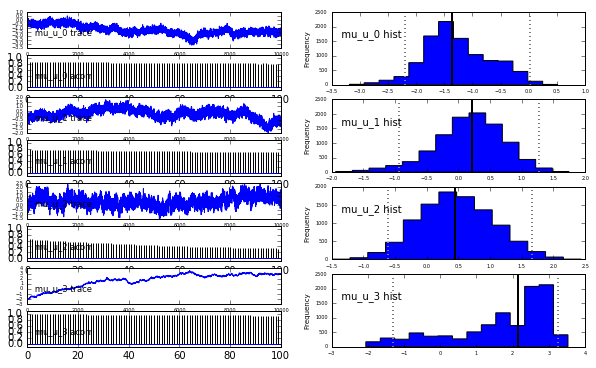

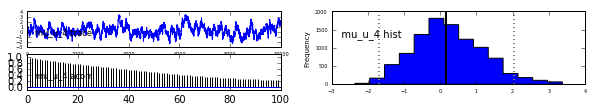

In [313]:
mcplot(mcmc.trace('mu_u'), common_scale=False)

Plotting mu_p_0
Plotting mu_p_1
Plotting mu_p_2
Plotting mu_p_3
Plotting mu_p_4


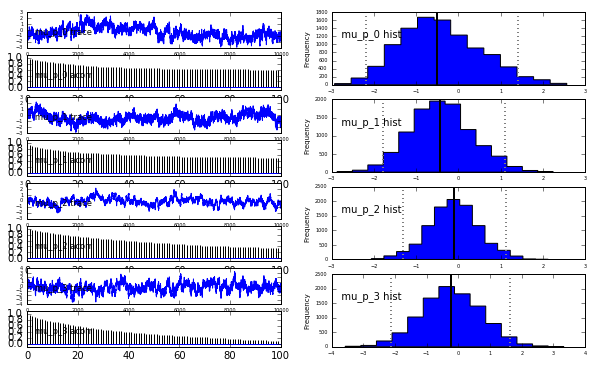

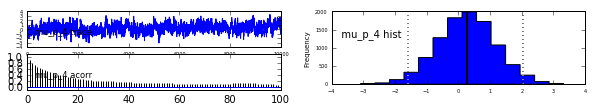

In [314]:
mcplot(mcmc.trace('mu_p'), common_scale=False)

Plotting P_2_0
Plotting P_2_1
Plotting P_2_2
Plotting P_2_3
Plotting P_2_4


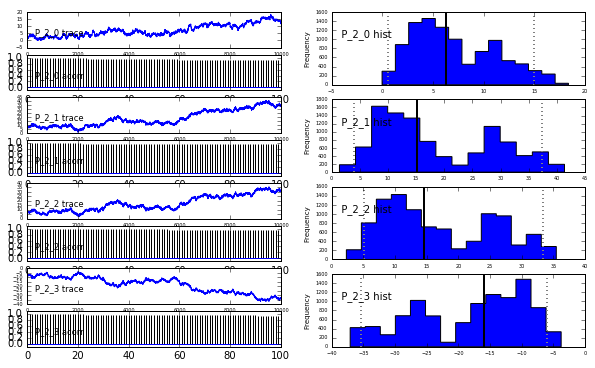

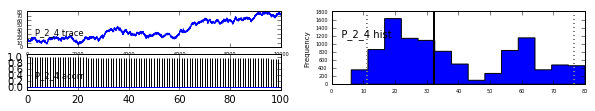

In [315]:
mcplot(mcmc.trace('P_2'), common_scale=False)